# Non-Stationary Kernels

In [ ]:
import tensorflow as tf
import numpy as np
import gpflow
gpflow.config.set_default_float(np.float32)
from gpflow.utilities.traversal import deepcopy

from sgptools.utils.misc import get_inducing_pts, cont2disc
from sgptools.methods import ContinuousSGP
from sgptools.kernels.attentive_kernel import AttentiveKernel
from sgptools.kernels.neural_kernel import init_neural_kernel
from sgptools.utils.gpflow import get_model_params, optimize_model

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12

np.random.seed(10)
tf.random.set_seed(10)

import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["QT_QPA_PLATFORM"] = "offscreen"

2025-06-26 15:40:34.971070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 15:40:34.971606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 15:40:34.974879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-26 15:40:34.983345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750970434.997420   18980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750970435.00

## Generate synthetic non-stationary data

Train Data: (800, 2) (800, 1)
Test Data: (5000, 2) (5000, 1)


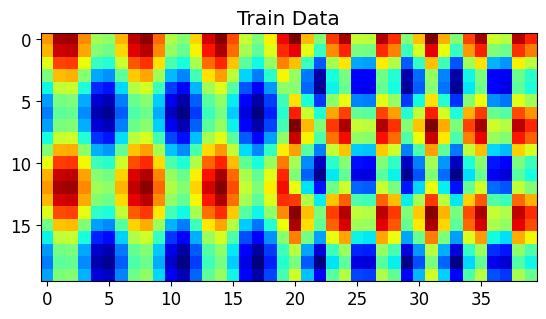

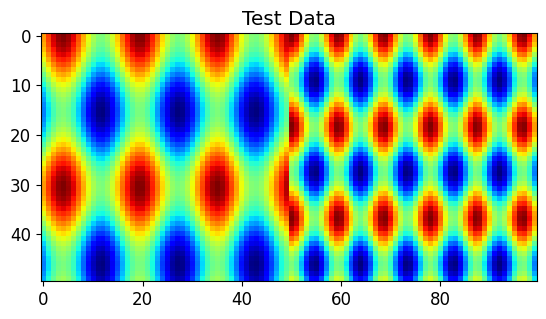

In [2]:
def non_stationary_function(X, Y):
    Z1 = np.sin(X/10) + np.cos(Y/10)
    Z2 = np.cos(X/6) + np.cos(Y/6)
    Z = np.concatenate([Z1[:, ::2], Z2[:, ::2]], 
                       axis=1)
    return Z

# Generate data
train_data_dims = (40, 20)
x = np.linspace(0, 200, train_data_dims[0])
y = np.linspace(0, 100, train_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_train = np.stack([X.ravel(), Y.ravel()], 
                   axis=1).astype(np.float32)
Y_train = Z.ravel()[:, None].astype(np.float32)
print('Train Data:', X_train.shape, Y_train.shape)

test_data_dims = (100, 50)
x = np.linspace(0, 200, test_data_dims[0])
y = np.linspace(0, 100, test_data_dims[1])
X, Y = np.meshgrid(x, y)
Z = non_stationary_function(X, Y)

X_test = np.stack([X.ravel(), Y.ravel()], 
                  axis=1).astype(np.float32)
Y_test = Z.ravel()[:, None].astype(np.float32)
print('Test Data:', X_test.shape, Y_test.shape)

# Normalize the data
Xscalar = StandardScaler()
X_train = Xscalar.fit_transform(X_train)
X_test = Xscalar.transform(X_test)

yScalar = StandardScaler()
Y_train = yScalar.fit_transform(Y_train)
Y_test = yScalar.transform(Y_test)

# Plot the data
plt.figure()
plt.imshow(Y_train.reshape(train_data_dims[1], 
                           train_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Train Data')
plt.show()

plt.figure()
plt.imshow(Y_test.reshape(test_data_dims[1], 
                          test_data_dims[0]), 
           cmap='jet')
plt.gca().set_aspect('equal')
plt.title('Test Data')
plt.show()

## Learn kernel parameters from train data 

In [3]:
kernels = []
noice_vars = []
labels = []

In [4]:
# Non Stationary Neural Kernel
model = init_neural_kernel(X_train, Y_train, 
                           n_inits=5,
                           inducing_variable=get_inducing_pts(X_train, 800, random=True),
                           Q=5, 
                           hidden_sizes=[4, 4])
model_ak = deepcopy(model)
optimize_model(model,
               optimizer='tf.Adam',
               learning_rate=1e-2)

kernels.append(model.kernel)
noice_vars.append(model.likelihood.variance.numpy())
labels.append('Neural Kernel')

In [5]:
# Non Stationary Attentive Kernel
gpflow.config.set_default_jitter(1e-1)
model_ak.kernel = AttentiveKernel(np.linspace(0.01, 2.0, 10))
optimize_model(model_ak,
               optimizer='tf.Adam',
               learning_rate=1e-2)

kernels.append(model_ak.kernel)
noice_vars.append(model_ak.likelihood.variance.numpy())
labels.append('Attentive Kernel')

In [6]:
# Stationary RBF Kernel
# get_model_params automatically handles GPR/SGPR creation and optimization.
# It returns the loss history, optimized noise variance, and the optimized kernel.
_, rbf_noise_variance, rbf_kernel = get_model_params(
    X_train=X_train, y_train=Y_train, 
    lengthscales=[1.0, 0.5], # Initial lengthscales for RBF
)

# Store the trained RBF kernel and noise variance
kernels.append(rbf_kernel)
noice_vars.append(rbf_noise_variance)
labels.append('RBF Kernel')

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │ 0.59705114              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float32 │ [1.16678    0.37066022] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ floa

## Continuous-SGP solution from each kernel function

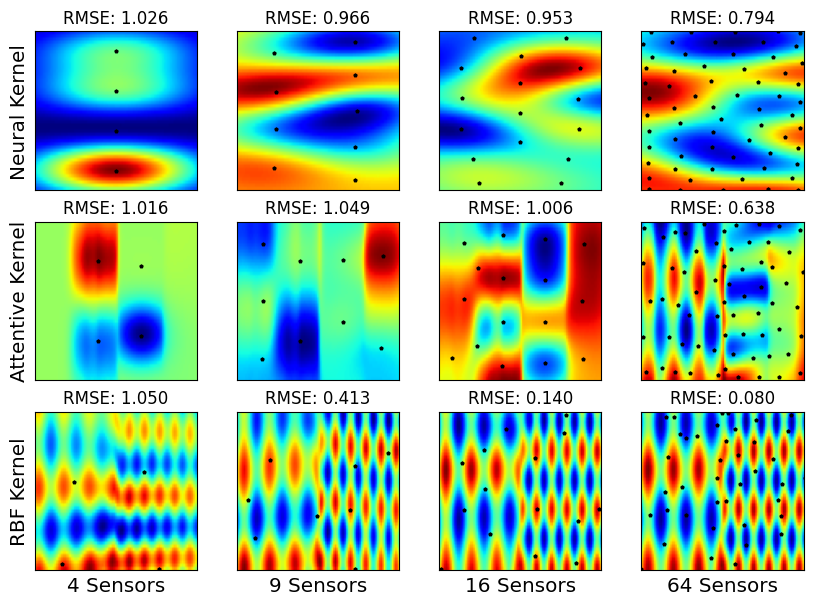

In [7]:
num_placements_list = [4, 9, 16, 64] # Number of sensor placements to evaluate
labels_reversed = labels[::-1] # Reverse labels to match the kernel order in the loop below

# Setup the matplotlib figure for plotting results
fig, axs = plt.subplots(len(kernels), len(num_placements_list), figsize=(10, 7))
# Iterate through each trained kernel and its corresponding noise variance
for i, (kernel, noice_var) in enumerate(zip(kernels[::-1], noice_vars[::-1])):
    for j, num_placements in enumerate(num_placements_list):
        # Get initial inducing points for the ContinuousSGP optimization
        # These will be the initial sensor locations.
        Xu_init = get_inducing_pts(X_train, num_placements)
        Xu_init = Xu_init.astype(np.float32) # Ensure data type consistency

        # Setup ContinuousSGP model
        # ContinuousSGP takes X_objective as the data for the SGPR model,
        # and Xu_init is passed as the initial inducing_variable.
        csgp_method = ContinuousSGP(
            num_sensing=num_placements, 
            X_objective=X_train, # Use X_train as the objective points for SGP
            kernel=kernel, # Pass the trained kernel
            noise_variance=noice_var, # Pass the trained noise variance
            X_init=Xu_init # Initial inducing points
        )

        # Optimize the ContinuousSGP model to find optimal sensor placements
        # The optimize method returns the optimized inducing points (sensor locations).
        # It reshapes the solution to (num_robots, num_sensing, num_dim) but here num_robots=1
        # so we flatten it back to (num_sensing, num_dim).
        sgp_sol_reshaped = csgp_method.optimize(max_steps=500, verbose=0) # Run optimization
        sgp_sol_sp = sgp_sol_reshaped.reshape(-1, X_train.shape[1])

        # Get the GP predictions
        Xu_X, Xu_y = cont2disc(sgp_sol_sp, 
                               candidates=X_test,
                               candidate_labels=Y_test)
        gpr = gpflow.models.GPR((Xu_X, Xu_y),
                                noise_variance=noice_var,
                                kernel=kernel)
        y_pred, y_var = gpr.predict_f(X_test)
        y_pred = y_pred.numpy()

        rmse = np.sqrt(np.mean((y_pred - Y_test)**2))

        # Plot the results
        axs[i, j].imshow(y_pred.reshape(test_data_dims[1], test_data_dims[0]),
                         cmap='jet', origin='lower',
                         extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                                 np.min(X_test[:, 1]), np.max(X_test[:, 1])])
        axs[i, j].set_aspect('equal')
        axs[i, j].scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], c='k', marker='p', s=5)
        axs[i, j].set_title(f'RMSE: {rmse:.3f}', fontsize='medium')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlim([np.min(X_test[:, 0]), np.max(X_test[:, 0])])
        axs[i, j].set_ylim([np.min(X_test[:, 1]), np.max(X_test[:, 1])])

        if j==0:
                axs[i, j].set_ylabel(f'{labels[i]}', fontsize='large')

        if i==len(kernels)-1:
                axs[i, j].set_xlabel(f'{num_placements} Sensors', fontsize='large')


- The neural kernel performs the best but requires a large amount of computational power
- The attentive kernel works well when given enough sensing locations